### Check if we have access to GPU

In [ ]:
import torch
torch.cuda.is_available()

True

### Download the data

In [ ]:
!wget https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2023-05-16 00:17:12--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  70.3MB/s    in 38s     

2023-05-16 00:17:51 (68.4 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



In [ ]:
!ls

Galaxy10_DECals.h5  sample_data


### Imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
import random
import h5py
import gc
import scipy

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [ ]:
gc.collect()

0

# How does the dataset look like?

In [ ]:
with h5py.File('Galaxy10_DECals.h5', 'r') as dataset:
    images = dataset['images']
    labels = dataset['ans']
    images = np.array(images)
    labels = np.array(labels)

train_img, val_img, train_label, val_label = train_test_split(images, labels, test_size=0.10, random_state=42)

del images; del labels
gc.collect()

del dataset
gc.collect()

0

In [ ]:
class_labels = [
    'Disturbed Galaxies',
    'Merging Galaxies',
    'Round Smooth Galaxies',
    'In-between Round Smooth Galaxies',
    'Cigar Shaped Smooth Galaxies',
    'Barred Spiral Galaxies',
    'Unbarred Tight Spiral Galaxies',
    'Unbarred Loose Spiral Galaxies',
    'Edge-on Galaxies without Bulge',
    'Edge-on Galaxies with Bulge'
    ]

fig = plt.figure(figsize=(6,10), dpi=300)

nrow, ncol = 10, 5
gs = GridSpec(nrow, ncol, hspace=0.1, width_ratios=[1.8,1,1,1,1])

for cl_idx in range(10):
    
    idxs = np.where(train_label==cl_idx)[0]
    ax = fig.add_subplot(gs[cl_idx*ncol])

    center_x = (ax.get_xlim()[1] - ax.get_xlim()[0]) / 2
    center_y = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2

    ax.text(center_x, center_y, class_labels[cl_idx] + f'\nclass {cl_idx}', ha='center', va='center', fontsize=6)
    ax.axis("off")

    for j in range(1, ncol):
        ax = fig.add_subplot(gs[cl_idx*ncol + j])
        ax.imshow(train_img[idxs[j-1]])
        ax.axis("off")

Output hidden; open in https://colab.research.google.com to view.

### Helper functions

In [ ]:
def get_loss_accuracy(model, dataloader):
    losses = []
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            if torch.cuda.is_available():
                xb = xb.cuda()
                yb = yb.cuda()
            ypred = model(xb)

            loss = nn.CrossEntropyLoss(reduction='none')(ypred, yb)
            losses.extend(loss.tolist())
            
            ypred = ypred.argmax(dim=1)
            correct_count += (ypred == yb).sum().item()
            total_count += ypred.size(0)

    return np.mean(losses), correct_count/total_count

### Datasets

In [ ]:
class MyDataset(Dataset):
    def __init__(self, img_array, label_array):
        # convert to tensor
        self.img_array   = img_array
        self.label_array = label_array

    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img   = torch.tensor(self.img_array[idx] / 255).float()
        img = img.permute(2, 0, 1)
        label = torch.tensor(self.label_array[idx])
        return img, label

In [ ]:
train_ds = MyDataset(train_img, train_label)
del train_img; del train_label
gc.collect()

val_ds   = MyDataset(val_img, val_label)
del val_img; del val_label
gc.collect()

0

In [ ]:
len(train_ds), len(val_ds)

(15962, 1774)

### Dataloaders

# <font color='cornflowerblue'>New argument `num_workers`</font>

In [ ]:
train_dl = DataLoader(train_ds, batch_size=250, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=5000, shuffle=False, num_workers=2)

### Let's build the network

In [ ]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(6, 8, 5)
        self.conv3 = nn.Conv2d(8, 4, 5)

        self.fc1 = nn.Linear(196, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
model = MyNN()

# put it on the GPU if it's available
if torch.cuda.is_available():
    model = model.cuda()

### Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training loop

In [ ]:
train_losses = []; val_losses = []
train_accuracy = []; val_accuracy = []

for ep in tqdm(range(20)):
    for xb, yb in train_dl:

        # put them on the GPU if the GPU is available:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()

        # remove the previous gradeints
        optimizer.zero_grad()

        pred = model(xb)

        # compute loss
        loss = nn.CrossEntropyLoss()(pred, yb)

        # compute the gradients
        loss.backward()
        
        # update the network
        optimizer.step()

    # bookkeeping
    avg_loss, acc = get_loss_accuracy(model, train_dl)
    train_losses.append(avg_loss)
    train_accuracy.append(acc)

    avg_loss, acc = get_loss_accuracy(model, val_dl)
    val_losses.append(avg_loss)
    val_accuracy.append(acc)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'accuracy')

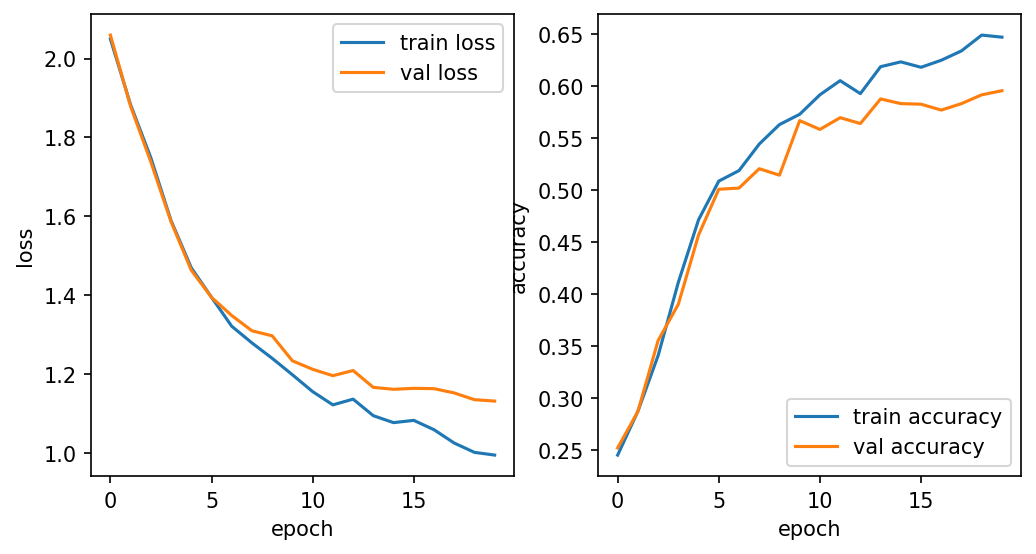

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=150)

ax = fig.add_subplot(121)
ax.plot(np.arange(len(train_losses)), train_losses, label='train loss')
ax.plot(np.arange(len(val_losses)), val_losses, label='val loss')
ax.legend()
ax.set_xlabel('epoch'); ax.set_ylabel('loss')

ax = fig.add_subplot(122)
ax.plot(np.arange(len(train_accuracy)), train_accuracy, label='train accuracy')
ax.plot(np.arange(len(val_accuracy)), val_accuracy, label='val accuracy')
ax.legend()
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')

# Where it works and where it fails

In [ ]:
y_truths = []; y_preds = []

for xb, yb in val_dl:
    if torch.cuda.is_available():
        xb = xb.cuda()
    ypred = model(xb)
    ypred = ypred.argmax(dim=1)

    y_truths.extend(yb.tolist())
    y_preds.extend(ypred.tolist())

y_truths = np.array(y_truths)
y_preds = np.array(y_preds)

correct_idxs = np.where(y_truths == y_preds)[0]
wrong_idxs = np.where(y_truths != y_preds)[0]


class_labels = [
    'Disturbed Galaxies',
    'Merging Galaxies',
    'Round Smooth Galaxies',
    'In-between Round Smooth Galaxies',
    'Cigar Shaped Smooth Galaxies',
    'Barred Spiral Galaxies',
    'Unbarred Tight Spiral Galaxies',
    'Unbarred Loose Spiral Galaxies',
    'Edge-on Galaxies without Bulge',
    'Edge-on Galaxies with Bulge'
    ]

fig = plt.figure(figsize=(8,12), dpi=200)

nrow, ncol = 5, 2
gs = GridSpec(1, 2, wspace=0.2)

gs_ = GridSpecFromSubplotSpec(nrow, ncol, subplot_spec=gs[0], hspace=0.5)
idxs = random.choices(correct_idxs, k=nrow*ncol)

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(gs_[i])
    ax.imshow(val_ds[idx][0].permute(1,2,0).detach().numpy())
    ax.axis("off")

    t_cl = class_labels[y_truths[idx]]
    p_cl = class_labels[y_preds[idx]]
    title = f'truth: {t_cl}\npred: {p_cl}'
    ax.set_title(title, fontsize=5)

gs_ = GridSpecFromSubplotSpec(nrow, ncol, subplot_spec=gs[1], hspace=0.5)
idxs = random.choices(wrong_idxs, k=nrow*ncol)

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(gs_[i])
    ax.imshow(val_ds[idx][0].permute(1,2,0).detach().numpy())
    ax.axis("off")

    t_cl = class_labels[y_truths[idx]]
    p_cl = class_labels[y_preds[idx]]
    title = f'truth: {t_cl}\npred: {p_cl}'
    ax.set_title(title, fontsize=5)

Output hidden; open in https://colab.research.google.com to view.